In [1]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

import pydicom

import pandas as pd

In [2]:
#hide
from nbdev.showdoc import *

# Project Pilot - Binary classification of chest X-rays for 'swallowed coin'
## Adapted from fastai tutorial https://docs.fast.ai/tutorial.medical_imaging.html


> In this notebook we will build a classifier that distinguishes between chest X-rays with a swallowed coin and chest X-rays without a swallowed coin. The coin in these images is always seen face-on, and has not been rotated. The image data is loaded from a local dataset of modified DICOM source files, which have been derived from a dataset of 250 chest X-rays that are included in the fastai package. DICOM data is handled directly. This notebook also goes through basic data exploration.

## Loading of X-ray DICOM files

First, we will define a path to the _siim_small_ folder containing a subset (250 DICOM files, \~30MB) of the [SIIM-ACR Pneumothorax Segmentation](https://doi.org/10.1007/s10278-019-00299-9) \[1\] dataset, which I have modified to include an artificial feature, a filled white circle, which resembles a coin, placed at a random location close to the trachea. I have added this 'coin' feature to these chest X-rays because no available dataset of chest X-rays exists for coin-like foreign bodies, so I have created my own. 

In [3]:
pneumothorax_source =  Path('mod_dataset/siim_small')

The _siim_small_ folder has the following directory/file structure, which was appropriate for the tutorial goal, which was the classification of chest X-rays by pneumonthorax presence. I have kept the folder structure the same to preserve that information, but I have used my own labels which are drawn from a dataframe.

![siim_folder_structure.jpg](../images/siim_folder_structure.jpeg)

### Plotting the DICOM data

In [4]:
df = pd.read_csv(pneumothorax_source/f"labels.csv")
df = df.rename(columns = {"calculus": "coin"})
df.head()

,file,label,coin
0,train/No Pneumothorax/000000.dcm,No Pneumothorax,False
1,train/Pneumothorax/000001.dcm,Pneumothorax,False
2,train/No Pneumothorax/000002.dcm,No Pneumothorax,False
3,train/Pneumothorax/000003.dcm,Pneumothorax,False
4,train/Pneumothorax/000004.dcm,Pneumothorax,False


In [5]:
items = get_dicom_files(pneumothorax_source/f"train/")

In [6]:
trn,val = RandomSplitter()(items)

We can use the `show` function to view a chest X-ray from a random patient without a coin in their trachea.

In [7]:
xray_sample_path = df.loc[(df['coin'] == False),'file'].sample(1).values[0]

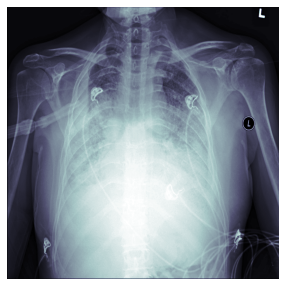

In [8]:
idx = items.index(pneumothorax_source/xray_sample_path)
xray_sample = items[idx].dcmread()
xray_sample.show()

We can also show a chest X-ray with an artificial 'coin' feature inserted in the trachea 

In [9]:
xray_sample_path = df.loc[(df['coin'] == True),'file'].sample(1).values[0]

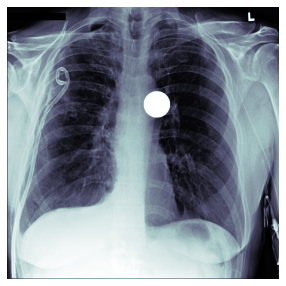

In [10]:
idx = items.index(pneumothorax_source/xray_sample_path)
xray_sample = items[idx].dcmread()
xray_sample.show()

This can be compared to a real chest X-ray of an actual coin impacted in the trachea (I have not modified the below image at all, and it is not part of my dataset). As you can see, my synthetic data looks a lot like the real thing.

![real coin in trachea](./images/coin_trachea.jpg)

As we are dealing with DICOM images, we need to use `PILDicom` as the `ImageBlock` category.  This is so the `DataBlock` will know how to open the DICOM images.  As this is a binary classification task we will use `CategoryBlock`.

In terms of the data here, we use the dataframe which contains paths and labels. Since the label 'coin' is the third column ('2' by python indexing) of each row, I will use a get_y function to pull that cell of a dataframe row.

I use the imagenet transforms that fastai recommends. These are appropriate because patients are often physically rotated and shifted accidentally when their chest x-rays are taken, which leads to images that can all be slightly rotated and shifted too.

In [11]:
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:pneumothorax_source/f"{x[0]}",
                   get_y=lambda x:x[2],
                   batch_tfms=[*aug_transforms(size=224),Normalize.from_stats(*imagenet_stats)])


Additionally, we plot a first batch with the specified transformations:

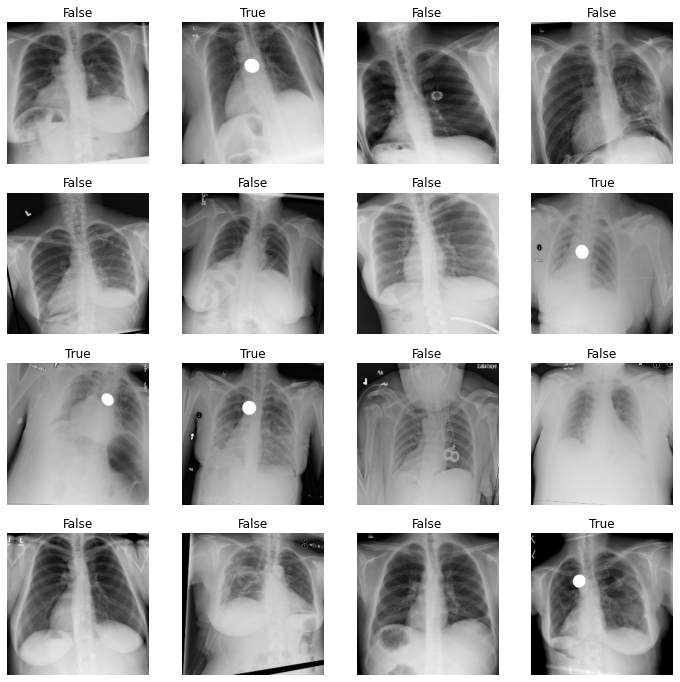

In [12]:
dls = pneumothorax.dataloaders(df.values)
dls.show_batch(max_n=16)

## Training

We can then use the `cnn_learner` function and initiate the training.

In [13]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

Use `lr_find` to try to find the best learning rate

SuggestedLRs(valley=0.002511886414140463)

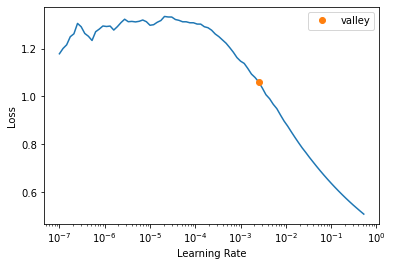

In [14]:
learn.lr_find()

In [15]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.257864,3.224826,0.300000,04:16
1,1.182681,1.111556,0.520000,02:20
2,1.089428,0.534223,0.720000,03:34
3,0.940913,0.261919,0.900000,04:34
4,0.854129,0.247875,0.900000,04:28
5,0.772027,0.203275,0.920000,03:12
6,0.707209,0.165452,0.920000,02:44
7,0.653038,0.130093,0.940000,04:53
8,0.594874,0.097680,0.960000,04:11
9,0.540187,0.084013,0.960000,04:07


In [16]:
tta = learn.tta(use_max=True)

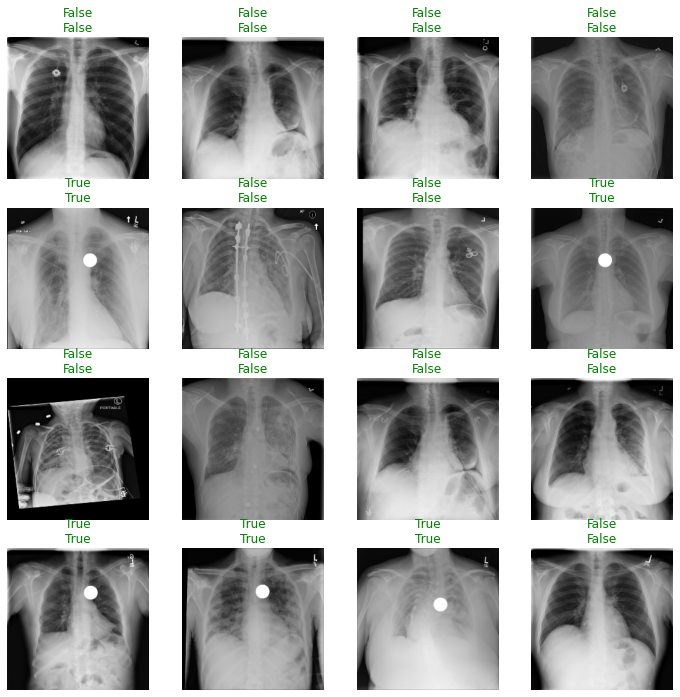

In [17]:
learn.show_results(max_n=16)

In [18]:
interp = Interpretation.from_learner(learn)

## Result Evaluation

Medical models are predominantly high impact so it is important to know how good a model is at detecting a certain condition. 

This model has an accuracy of 56%. Accuracy can be defined as the number of correctly predicted data points out of all the data points. However in this context we can define accuracy as the probability that the model is correct and the patient has the condition **PLUS** the probability that the model is correct and the patient does not have the condition

There are some other key terms that need to be used when evaluating medical models:

**False Positive & False Negative**

- **False Positive** is an error in which a test result improperly indicates presence of a condition, such as a disease (the result is positive), when in reality it is not present


- **False Negative** is an error in which a test result improperly indicates no presence of a condition (the result is negative), when in reality it is present

**Sensitivity & Specificity**

- **Sensitivity or True Positive Rate** is where the model classifies a patient has the disease given the patient actually does have the disease. Sensitivity quantifies the avoidance of false negatives


Example: A new test was tested on 10,000 patients, if the new test has a sensitivity of 90% the test will correctly detect 9,000 (True Positive) patients but will miss 1000 (False Negative) patients that have the condition but were tested as not having the condition

- **Specificity or True Negative Rate** is where the model classifies a patient as not having the disease given the patient actually does not have the disease. Specificity quantifies the avoidance of false positives

[Understanding and using sensitivity, specificity and predictive values](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2636062/) is a great paper if you are interested in learning more about understanding sensitivity, specificity and predictive values.

**PPV and NPV**

Most medical testing is evaluated via **PPV** (Positive Predictive Value) or **NPV** (Negative Predictive Value).

**PPV** - if the model predicts a patient has a condition what is the probability that the patient actually has the condition

**NPV** - if the model predicts a patient does not have a condition what is the probability that the patient actually does not have the condition

The ideal value of the PPV, with a perfect test, is 1 (100%), and the worst possible value would be zero

The ideal value of the NPV, with a perfect test, is 1 (100%), and the worst possible value would be zero

**Confusion Matrix**

The confusion matrix is plotted against the `valid` dataset

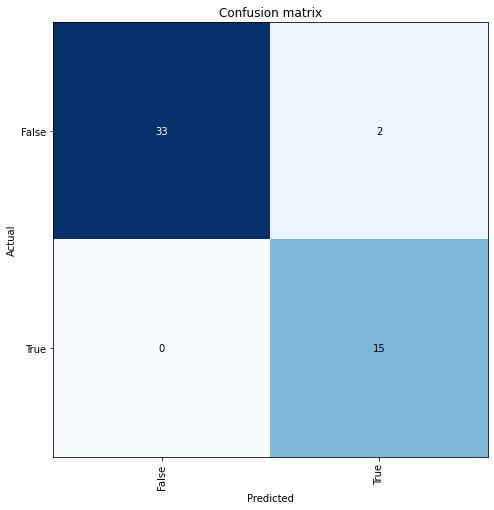

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

You can also reproduce the results interpreted from plot_confusion_matrix like so:

In [20]:
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

33 2 0 15


Note that **Sensitivity = True Positive/(True Positive + False Negative)**

In [21]:
sensitivity = tp/(tp + fn)
sensitivity

1.0

In this case the model has a sensitivity of 100% and hence capable of correctly detecting 100% True Positives (i.e. who have a coin in the trachea) and will not predict a False Negatives (patients that actually have a coin in the trachea but were told they did not!).

This is also know as a **Type II error**

This is a fantastic result, as type II error is particularly dangerous in medicine, because it represents a 'missed' diagnosis.

**Specificity = True Negative/(False Positive + True Negative)**

In [29]:
specificity = tn/(fp + tn)
specificity

0.9428571428571428

The model has a specificity of 94% and hence can correctly detect 94% of the time that a patient does **not** have a coin in the trachea but will incorrectly classify that 6% of the patients have coin in the trachea (False Postive) but actually do not.

This is also known as a **Type I error**

**Positive Predictive Value (PPV)**

In [30]:
ppv = tp/(tp+fp)
ppv

0.8823529411764706

In this case the model performs well in correctly predicting patients with coin in the trachea.

**Negative Predictive Value (NPV)**

In [31]:
npv = tn/(tn+fn)
npv

1.0

This model performed perfectly at predicting patients with no coin in the trachea.

**Calculating Accuracy**

The accuracy of this model as mentioned before was 56% but how was this calculated? We can consider accuracy as:

**accuracy = sensitivity x prevalence + specificity * (1 - prevalence)**

Where **prevalence** is a statistical concept referring to the number of cases of a disease that are present in a particular population at a given time. The prevalence in this case is how many patients in the valid dataset have the condition compared to the total number.

To view the files in the valid dataset you call `dls.valid_ds.cat`

In [32]:
val = dls.valid_ds.cat
#val[0]

In [35]:
val[0]

<bound method L.cat of TfmdLists: [['train/No Pneumothorax/000203.dcm' 'No Pneumothorax' True]
 ['train/Pneumothorax/000021.dcm' 'Pneumothorax' False]
 ['train/No Pneumothorax/000224.dcm' 'No Pneumothorax' False]
 ['train/No Pneumothorax/000249.dcm' 'No Pneumothorax' False]
 ['train/Pneumothorax/000003.dcm' 'Pneumothorax' False]
 ['train/Pneumothorax/000185.dcm' 'Pneumothorax' False]
 ['train/No Pneumothorax/000137.dcm' 'No Pneumothorax' False]
 ['train/No Pneumothorax/000176.dcm' 'No Pneumothorax' True]
 ['train/Pneumothorax/000139.dcm' 'Pneumothorax' True]
 ['train/No Pneumothorax/000220.dcm' 'No Pneumothorax' False]
 ['train/No Pneumothorax/000206.dcm' 'No Pneumothorax' False]
 ['train/Pneumothorax/000191.dcm' 'Pneumothorax' False]
 ['train/No Pneumothorax/000190.dcm' 'No Pneumothorax' False]
 ['train/No Pneumothorax/000012.dcm' 'No Pneumothorax' True]
 ['train/Pneumothorax/000010.dcm' 'Pneumothorax' False]
 ['train/Pneumothorax/000217.dcm' 'Pneumothorax' False]
 ['train/No Pneumoth

In [38]:
len(dls.valid_ds)

50

There are 15 trachea-coin images in the valid set (which has a total of 50 images and can be checked by using `len(dls.valid_ds)`) so the prevalence here is 15/50 = 0.3

In [39]:
prevalence = 15/50
prevalence

0.3

In [40]:
accuracy = (sensitivity * prevalence) + (specificity * (1 - prevalence))
accuracy

0.96

In [ ]:
An accuracy of 96%

_**Citations:**_

\[1\] _Filice R et al. Crowdsourcing pneumothorax annotations using machine learning annotations on the NIH chest X-ray dataset.  J Digit Imaging (2019). https://doi.org/10.1007/s10278-019-00299-9_